In [1]:
%matplotlib widget
import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pathlib import Path

from afr3d.io.step_import import extract_solids, load_step

step_path = Path("../data/example_complex.stp")
shape_raw = load_step(step_path)
shape = extract_solids(shape_raw)

In [8]:
import matplotlib.pyplot as plt
from afr3d.views.plotting import (
    draw_edge_segments, build_hlr_projection_ax2,
    draw_analytic_view_edges, draw_hlr_compound
)
from afr3d.views.analytic import (
    build_outline_segments_from_hlr,
    build_edge_segments_from_labels,
    classify_edge_samples_by_hlr,
    build_analytic_view_2d
)
from afr3d.views.orientation import make_default_front_top_side_ax2

In [3]:
axes_map = make_default_front_top_side_ax2(shape)

In [4]:
side_ax2 = axes_map["side"]

In [ ]:
projection_new, _ = build_hlr_projection_ax2(shape, side_ax2)

side_view_new = build_analytic_view_2d(
    shape,
    view_ax2=side_ax2,
    view_name="side",
    face_visibility=None,
    n_edge_samples=64,   # плотность семплов аналитического ребра
)

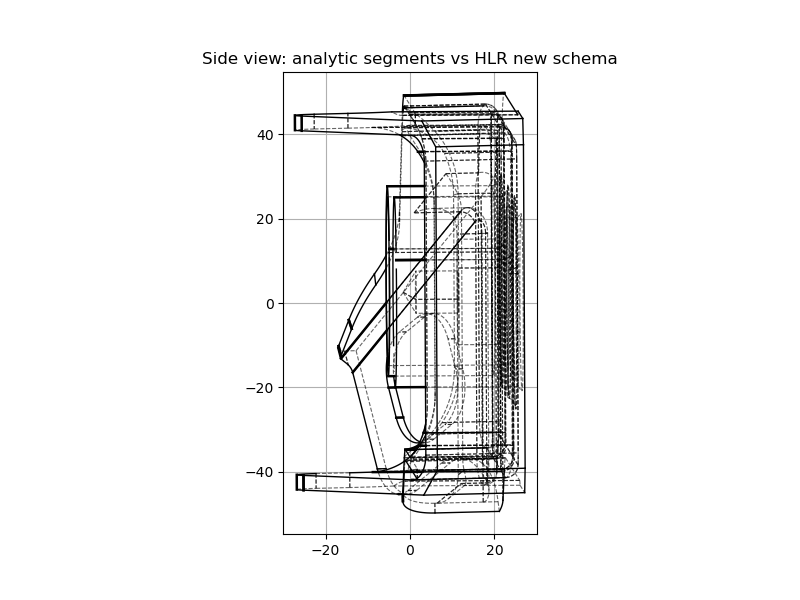

In [6]:
# 1. делаем snapshot старой видимости до HLR-уточнения
old_vis = {idx: e.visibility for idx, e in side_view_new.edges.items()}

# 2. классификация по HLR
labels_per_edge = classify_edge_samples_by_hlr(
    side_view_new,
    projection_new,
    n_samples_hlr=64,
    tol_factor=1e-3,
)

# 3. сегменты с fallback
edge_segments = build_edge_segments_from_labels(
    side_view_new,
    labels_per_edge,
    min_run=3,
    fallback_visibility=old_vis,
)

outline_segments = build_outline_segments_from_hlr(projection_new, n_samples=64)
segments = edge_segments + outline_segments

# 4. Смотрим, как это выглядит
fig, ax = draw_edge_segments(segments, title="Side view: analytic segments vs HLR new schema")
plt.show()

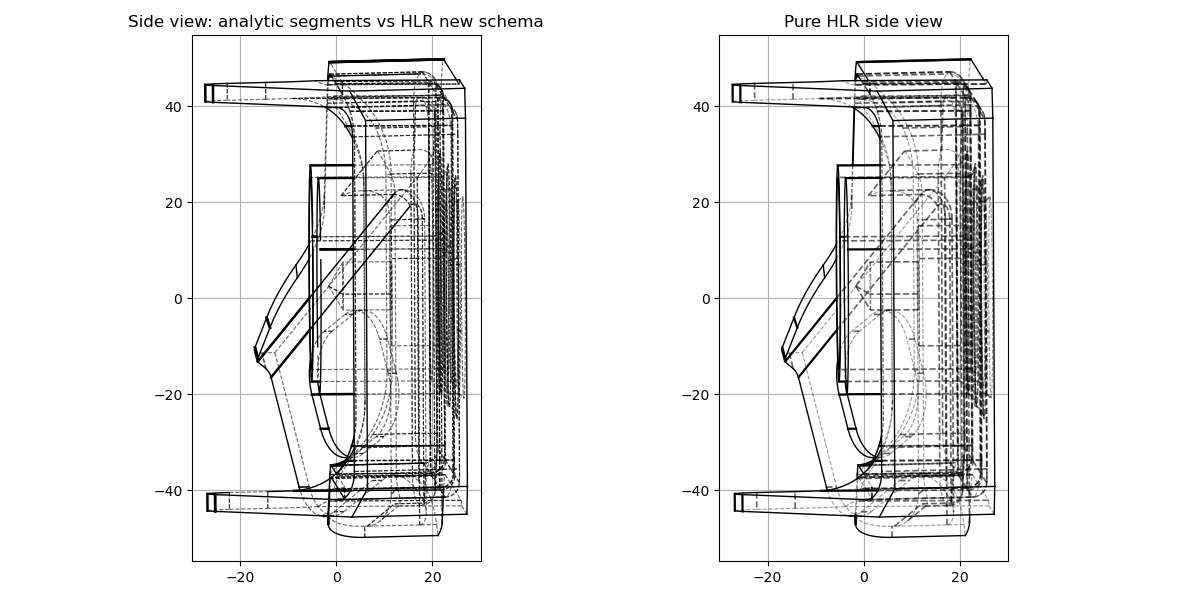

In [ ]:
# 1. HLR и аналитика в одной Ax2
side_projection, _ = build_hlr_projection_ax2(shape, side_ax2)

vis      = side_projection["visible"]
hid      = side_projection["hidden"]
out_vis  = side_projection["outline_visible"]
out_hid  = side_projection["outline_hidden"]

# 2. Два subplot'а: слева — analytic, справа — HLR
fig, (ax_ana, ax_hlr) = plt.subplots(1, 2, figsize=(12, 6))
ax_ana.set_aspect("equal", "box")
ax_hlr.set_aspect("equal", "box")

# слева — аналитический вид (только видимые + силуэтные, скрытые тоже можно включить)
draw_edge_segments(segments, fig_ax=(fig, ax_ana), title="Side view: analytic segments vs HLR new schema")

# справа — натуральный HLR
# порядок: сначала скрытое, потом видимое, чтобы видимое легло сверху
draw_hlr_compound(ax_hlr, out_hid, color="black", linestyle="--", linewidth=1.2, alpha=0.6)
draw_hlr_compound(ax_hlr, hid,      color="black", linestyle="--", linewidth=0.8, alpha=0.4)
draw_hlr_compound(ax_hlr, out_vis,  color="black", linestyle="-",  linewidth=1.6, alpha=1.0)
draw_hlr_compound(ax_hlr, vis,      color="black", linestyle="-",  linewidth=1.0, alpha=1.0)

ax_hlr.grid(True)
ax_hlr.set_title("Pure HLR side view")

plt.tight_layout()
plt.show()